In [1]:
import numpy as np
from skimage import io
from skimage.transform import rescale
import matplotlib.pyplot as plt

In [2]:
imgs_small = io.imread_collection('data/small/*')
imgs_big = io.imread_collection('data/big/*')

In [29]:
def get_rgb_img(img_bgr):
    line = img_bgr.shape[0] // 3
    edge = int(0.1 * img_bgr.shape[1])
    return {
        'b': img_bgr[edge: line - edge, edge: -edge],
        'g': img_bgr[line + edge: 2 * line - edge, edge: -edge],
        'r': img_bgr[2 * line + edge: 3 * line - edge, edge: -edge],
    }

In [4]:
class MSE:
    err = np.inf
    
    def reset(self):
        self.err = np.inf
    
    def cmp(self, x):
        return x < self.err
    
    @staticmethod
    def score(img1, img2):
        if img1.size != img2.size:
            raise Exception('DIFFERENT SIZES!')

        return ((img1.astype(np.float) - img2.astype(np.float)) ** 2).sum() / img1.size
    
class CC:
    err = -1
    
    def reset(self):
        self.err = -1
    
    def cmp(self, x):
        return x > self.err
    
    @staticmethod
    def score(img1, img2):
        if img1.size != img2.size:
            raise Exception('DIFFERENT SIZES!')
        
        img1 = img1.astype(np.float)
        img2 = img2.astype(np.float)
        return (img1 * img2).sum() / np.sqrt((img1 ** 2).sum() * (img2 ** 2).sum())

In [5]:
def shift_img(img, x, y):
        img = np.roll(img, x, axis=0)
        return np.roll(img, y, axis=1)

def get_best_match(img1, img2, metric, pix_range=15):
    metric.reset()
    h, w = img1.shape
    i = 0

    for pix_x in range(-pix_range, pix_range):
        for pix_y in range(-pix_range, pix_range):
            err = metric.score(shift_img(img1, pix_x, pix_y), img2)
            if metric.cmp(err):
                metric.err = err
                pix_best = [pix_x, pix_y]

    return np.array(pix_best)

def make_rgb_img(img_rgb, fixed_ch, shift, ignore_ch=''):
    height, width = img_rgb[fixed_ch].shape
    ch_indx = {'r': 0, 'g': 1, 'b': 2}
    
    channels = set(['r', 'g', 'b'])
    channels.discard(fixed_ch)
    channels.discard(ignore_ch)

    img_c = np.zeros((*img_rgb[fixed_ch].shape, 3), dtype=np.uint8)
    img_c[..., ch_indx[fixed_ch]] = img_rgb[fixed_ch]

    for c in channels:
        img_c[..., ch_indx[c]] = shift_img(img_rgb[c], shift[c][0], shift[c][1])
            
    return img_c

[ 8 -1] [-7  0]


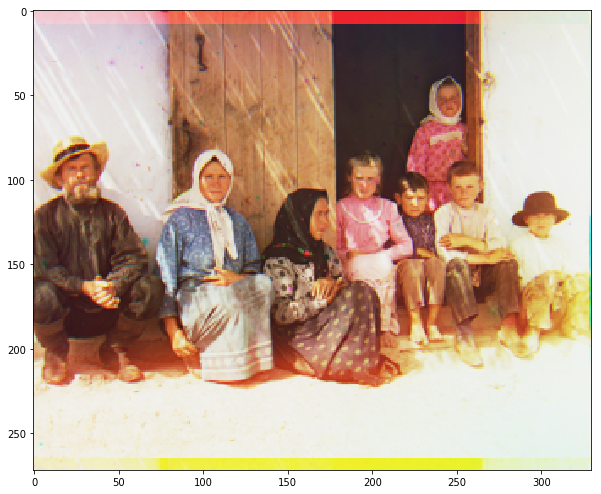

In [30]:
img_rgb = get_rgb_img(imgs_small[7])

red = get_best_match(img_rgb['r'], img_rgb['g'], MSE())
blue = get_best_match(img_rgb['b'], img_rgb['g'], MSE())

print(red, blue)

img_c = make_rgb_img(img_rgb, 'g', {'r': red, 'b': blue})
plt.figure(figsize=(10, 10))
plt.imshow(img_c)
plt.show()

In [34]:
def pyramid_align(img1, img2, metric):
    if img1.shape[0] < 400:
        return get_best_match(img1, img2, metric)
    else:
        shift = 2 * pyramid_align(rescale(img1, 0.5),
                                  rescale(img2, 0.5),
                                  metric)

        return shift + get_best_match(shift_img(img1, *shift), img2, metric, 2)

In [35]:
img_rgb = get_rgb_img(imgs_big[7])

[75 -7] [-67  -2]


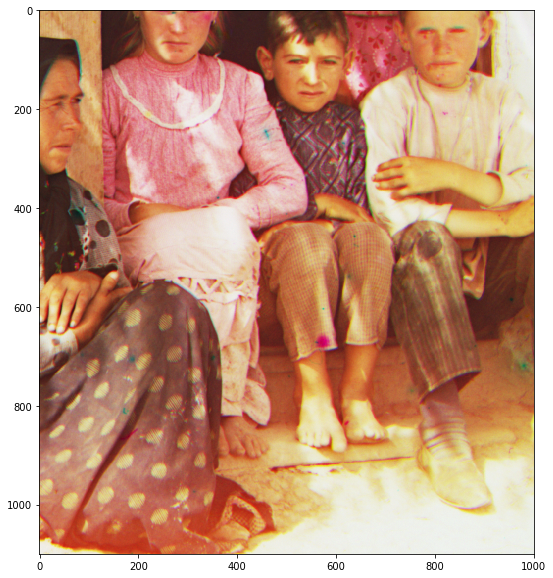

In [36]:
red = pyramid_align(img_rgb['r'], img_rgb['g'], MSE())
blue = pyramid_align(img_rgb['b'], img_rgb['g'], MSE())

print(red, blue)

img_c = make_rgb_img(img_rgb, 'g', {'r': red, 'b': blue})
plt.figure(figsize=(10, 10))
plt.imshow(img_c[900:2000, 1500:2500])
plt.show()